# Other compartmented models

In [16]:
# maths
from numpy import linspace
from numpy.random import default_rng

# networks
import networkx

# data handling
import pandas
from pathlib import Path
datasets = Path("../../datasets")
datasets.mkdir(parents=True, exist_ok=True)

# simulation
from epyc import Experiment, JSONLabNotebook, ParallelLab
from epydemic import ERNetwork, StochasticDynamics, SIR

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

In [4]:
class SIRDS(SIR):
    '''A compartmented model representing a disease with limited-time immunity and
    where we track the number of people who die rather than recovering.'''
    
    # Extra model parameters
    P_DIE = "pDie"
    T_RESUSCEPT = "tResucept"
    
    # Additional compartments
    DIED = "D"
    
    def __init__(self):
        super().__init__()
        
    def build(self, params):
        '''Build the model.
        
        :params params: the experimental parameters'''
        super().build(params)
        
        # remember the re-susceptibility time
        self._tResuscept = params[self.T_RESUSCEPT]
        
    def remove(self, t, n):
        '''Event triggered when someone acquires immunity. They
        retain this immunity for a fixed time.
        
        :param t: simuation time
        :param n: node that dies'''
        self.changeCompartment(n, self.REMOVED)
        
        # post the event that removes their immunity
        self.postEvent(t + self._tResuscept, n, self.resuscept)
        
    def die(self, t, n):
        '''Event triggered when someone dies (instead of recovering to immunity).
        
        :param t: simuation time (ignored)
        :param n: node that dies'''
        self.changeCompartment(n, self.DIED)
        
    def resuscept(self, t, n):
        '''Event triggered when someone reverts to susceptible.
        
        :param t: simuation time (ignored)
        :param n: node that loses immunity'''
        self.changeCompartment(n, self.SUSCEPTIBLE)

In [22]:
N = int(1e4)
kmean = 10

In [13]:
# load our previous notebook
nb = JSONLabNotebook(Path(datasets, "09-12-sirds.json"))

In [8]:
from multiprocessing import cpu_count
print("Current system has {c} cores in total".format(c=cpu_count()))

Current system has 16 cores in total


In [9]:
# pick the number of cores -- change this to change parallelism
nCores = 6

In [14]:
# create the lab
lab = ParallelLab(notebook=nb, cores=nCores)

In [28]:
def make_sirds(pInfect, pDie = None, tResuscept = None, reps = 10):
    
    def sirds(lab):
        lab[SIRDS.P_INFECTED] = 0.001
        lab[SIRDS.P_INFECT] = pInfect
        lab[SIRDS.P_REMOVE] = 1.0
        lab['reps'] = range(reps)
        if pDie is None:
            lab[SIRDS.P_DIE] = linspace(0.1, 1.0, num=100)
        else:
            lab[SIRDS.P_DIE] = pDie
        if tResuscept is None:
            lab[SIRDS.T_RESUSCEPT] = linspace(0.1, 1.0, num=100)
        else:
            lab[SIRDS.T_RESUSCEPT] = tResuscept
            
    return sirds

In [29]:
lab.createWith("sirds_0d_1r",
               make_sirds(linspace(0.0, 0.2), pDie=0.0, tResuscept=1.0, reps=10),
               "SIRDS epidemic for low values of pInfect, no death, unit re-susceptibility")

True

KeyError: 'epydemic.sir.pInfect'

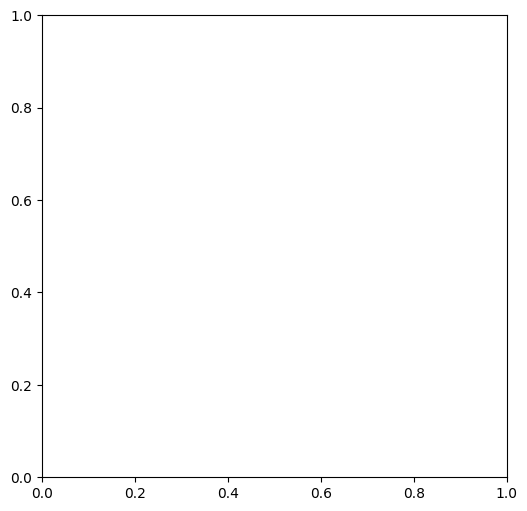

In [30]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the mean sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sirds_0d_1r")
pInfects = sorted(df[SIR.P_INFECT].unique())              # extract the experimental pInfect values
rs_mean = (df.groupby(SIR.P_INFECT))[SIR.REMOVED].mean()  # compute the mean of the repetitions at each pInfect
ax.plot(pInfects, rs_mean, 'r-', label="mean")

# fill in the title and axis labels
ax.set_title(f'Total size of outbreak, mean of {reps} repetitions')
ax.set_xlabel('$p_{infect}$')
ax.set_xticks(pInfects[::25])                  # only label some selected points
ax.set_ylabel('Number of infecteds')
ax.legend(loc='upper left')
plt.show()